In [1]:
#!/usr/bin/env python
"""
@author: Jayant Gupta
last update: 02.06.2021
"""

'\n@author: Jayant Gupta\nlast update: 02.06.2021\n'

In [2]:
# Import necessary libraries
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow, show
from skimage.transform import resize
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from PIL import Image

# Handles reading large number of files.
Image.MAX_IMAGE_PIXELS = 219494175 

In [3]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

# This function creates a dictionary to store images and their mask.
# This function is curated to handle images in *_num-num format.
# This function is designed to work with a single tiff tile.
# def add_to_dict(train_mask_pair, list_of_files, IMG_PATH, MASK_PATH):
#     for entry in list_of_files:
#         if entry.endswith("jpeg"):
#             key = entry.split('_')[-1].split('.')[0]
#             if key in train_mask_pair:
#                 train_mask_pair[key].append(os.path.join(MASK_PATH, entry))
#             else:
#                 train_mask_pair[key] = [os.path.join(IMG_PATH, entry)]   

# This function creates a dictionary to store images and their mask.
# This function is curated to handle train images *.tif format and 
# mask file in *.jpeg format

def add_to_dict(img_files, mask_files, IMG_PATH, MASK_PATH):
    image_mask_pair = {}
    for entry in img_files:
        if entry.endswith("tif"):
            key = entry.split('.')[0]
            image_mask_pair[key] = [os.path.join(IMG_PATH, entry)]
    for entry in mask_files:
        if entry.endswith('jpeg'):
            key = entry.split('m')[0][:-1]
            if key in image_mask_pair:
                image_mask_pair[key].append(os.path.join(MASK_PATH, entry))
    return image_mask_pair

def get_image_mask_pair(Image_Path, Mask_Path):
  # Image_Path = '/Users/jayantgupta/Desktop/SV/Hennepin_North'
  # Mask_Path = '/Users/jayantgupta/Desktop/SV/Hennepin_North_Mask'
    imgs = os.listdir(Image_Path)
    mask = os.listdir(Mask_Path)

    image_mask_pair = add_to_dict(imgs, mask, Image_Path, Mask_Path)

    count = 0
    for key in image_mask_pair.keys():
        if count > 5: 
            break
        print (image_mask_pair[key])
        count += 1
    return image_mask_pair

# #train_mask_pair = {**train_mask_mpls_pair, **train_mask_stp_pair} # For OSFA
# #test_mask_pair = {**test_mask_mpls_pair, **test_mask_stp_pair}    # For OSFA 
Mask_Path = 'datasets/MN_raster_Hennepin_North_Mask'
Image_Path = 'datasets/MN_raster_Hennepin_North'
image_mask_pair = get_image_mask_pair(Image_Path, Mask_Path)

['datasets/MN_raster_Hennepin_North\\120_23_13_01.tif', 'datasets/MN_raster_Hennepin_North_Mask\\120_23_13_01_mask.jpeg']
['datasets/MN_raster_Hennepin_North\\120_23_13_02.tif', 'datasets/MN_raster_Hennepin_North_Mask\\120_23_13_02_mask.jpeg']
['datasets/MN_raster_Hennepin_North\\120_23_13_03.tif', 'datasets/MN_raster_Hennepin_North_Mask\\120_23_13_03_mask.jpeg']
['datasets/MN_raster_Hennepin_North\\120_23_13_04.tif', 'datasets/MN_raster_Hennepin_North_Mask\\120_23_13_04_mask.jpeg']
['datasets/MN_raster_Hennepin_North\\120_23_14_01.tif', 'datasets/MN_raster_Hennepin_North_Mask\\120_23_14_01_mask.jpeg']
['datasets/MN_raster_Hennepin_North\\120_23_14_02.tif', 'datasets/MN_raster_Hennepin_North_Mask\\120_23_14_02_mask.jpeg']


In [4]:
# Function to read the data from image_mask_pair file paths.
def read_data(train_mask_pair):
    X_train = np.zeros((len(train_mask_pair), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_mask_pair), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    keys = train_mask_pair.keys()

    print('Resizing training images and masks')
    n = 0
    for key, value in tqdm(train_mask_pair.items()):
        img_path = value[0]
        img = Image.open(img_path) # Using Pillow Image object
        img = img.resize((IMG_HEIGHT, IMG_WIDTH)) # 
        X_train[n] = np.array(img)  #Fill empty X_train with values from img
        mask_path = value[1]
        mask = Image.open(mask_path) # Using Pillow Image object
        #mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        mask = mask.resize((IMG_HEIGHT, IMG_WIDTH))
        mask = np.array(mask)
        mask = mask.reshape(256, 256, 1)
        mask_bool = mask > 0          
        Y_train[n] = mask_bool 
        n += 1
    return X_train, Y_train

X_train, Y_train = read_data(image_mask_pair)

100%|██████████| 36/36 [01:10<00:00,  1.95s/it]


In [6]:
# Need to run once. Generate training, validation, and test dataset.
def generate_train_val_test(X_train, Y_train):
    X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 1)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.12, random_state = 1)
    print("Train Size = {0}, Test size = {1}, Validation size = {2}".format(len(X_train), len(X_test), len(X_val)))
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

X_train, Y_train, X_val, Y_val, X_test, Y_test = generate_train_val_test(X_train, Y_train)

outfile = 'datasets/PYObjects/Hennepin_North.npz'
np.savez(outfile ,X_train=X_train, Y_train=Y_train, X_val=X_val, Y_val=Y_val, X_test=X_test, Y_test=Y_test)

Train Size = 22, Test size = 3, Validation size = 3


In [7]:
outfile = 'datasets/PYObjects/Hennepin_North.npz'
npzfile = np.load(outfile)
print(npzfile.files)
X_train = npzfile['X_train']
Y_train = npzfile['Y_train']
X_test = npzfile['X_test']
Y_test = npzfile['Y_test']
X_val = npzfile['X_val']
Y_val = npzfile['Y_val']

['X_train', 'Y_train', 'X_val', 'Y_val', 'X_test', 'Y_test']


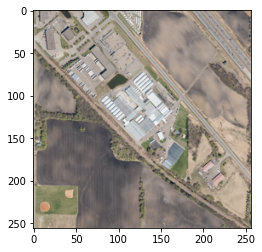

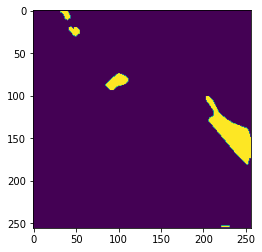

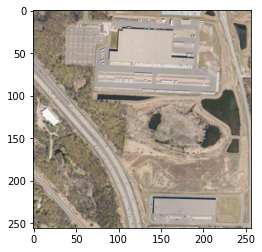

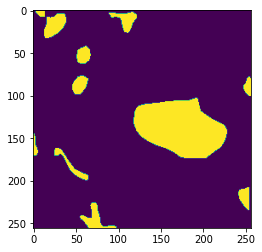

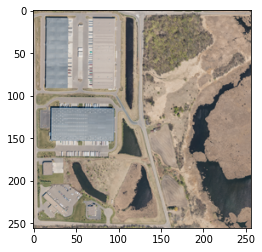

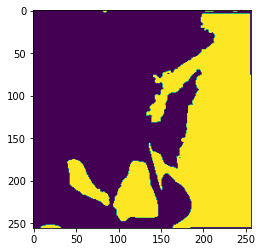

In [8]:
image_x = random.randint(0, len(X_train)-1)
plt.imshow(X_train[image_x])
plt.figure()
plt.imshow(np.squeeze(Y_train[image_x]))
plt.show()

image_x = random.randint(0, len(X_test)-1)
plt.imshow(X_test[image_x])
plt.figure()
plt.imshow(np.squeeze(Y_test[image_x]))
plt.show()

image_x = random.randint(0, len(X_val)-1)
plt.imshow(X_val[image_x])
plt.figure()
plt.imshow(np.squeeze(Y_val[image_x]))
plt.show()

In [13]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

#Expansive path 
u4 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
u4 = tf.keras.layers.concatenate([u4, c2])
c4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

u5 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
u5 = tf.keras.layers.concatenate([u5, c1], axis=3)
c5 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

################################

#class CustomCallback(keras.callbacks.Callback):
#    def on_train_batch_begin(self, batch, logs=None):
#        if not hasattr(self.model.optimizer, "lr"):
#            raise ValueError('Optimizer must have a "lr" attribute.')
#        lr = float(tf.keras.backend.get_value(self.model.optimizer_learning_rate))
# sample_weights        

#Define call backs here.
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath='datasets/2021_weights/OSFA-UNetS.h5', verbose=1, save_best_only=True)]

# Check sample weighting
sample_weight = np.ones(shape=(len(Y_train),))

#results = model.fit(X_train, Y_train, sample_weight = sample_weight, validation_split=0.1, batch_size=8, epochs=10, callbacks=callbacks)
results = model.fit(X_train, Y_train, sample_weight = sample_weight, validation_data=(X_val, Y_val), batch_size=8, epochs=10, callbacks=callbacks)

####################################

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 16) 448         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_23 (Dropout)            (None, 256, 256, 16) 0           conv2d_49[0][0]                  
____________________________________________________________________________________________

In [12]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

################################

#class CustomCallback(keras.callbacks.Callback):
#    def on_train_batch_begin(self, batch, logs=None):
#        if not hasattr(self.model.optimizer, "lr"):
#            raise ValueError('Optimizer must have a "lr" attribute.')
#        lr = float(tf.keras.backend.get_value(self.model.optimizer_learning_rate))
# sample_weights        

#Modelcheckpoint
#checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='/Users/jayantgupta/SVANN/model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath='datasets/MPLS-UNet.h5', verbose=1, save_best_only=True)]

# Check sample weighting
#sample_weight = np.ones(shape=(len(Y_train),))

#results = model.fit(X_train, Y_train, sample_weight = sample_weight, validation_split=0.1, batch_size=16, epochs=3, callbacks=callbacks)

####################################

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 256, 256, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 256, 256, 16) 0           conv2d_30[0][0]                  
____________________________________________________________________________________________

1/1 [==============================] - 0s 117ms/step


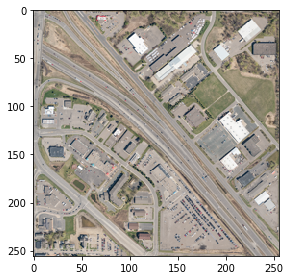

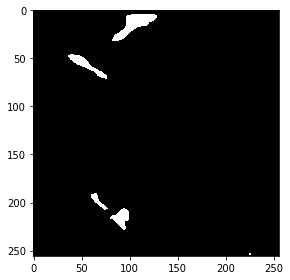

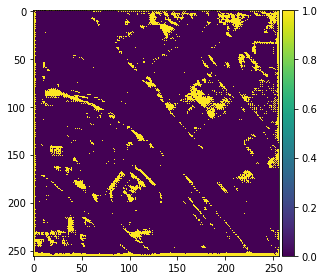

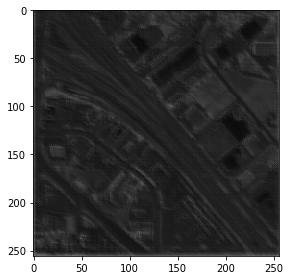

In [14]:
weight_file = 'datasets/2021_weights/OSFA-UNetS.h5'
model.load_weights(weight_file)

preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.2).astype(np.uint8)
preds_val_t = (preds_val > 0.2).astype(np.uint8)
preds_test_t = (preds_test > 0.2).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t)-1)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()
imshow(np.squeeze(preds_train[ix]))
plt.show()

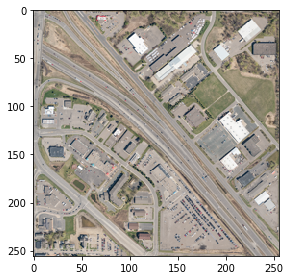

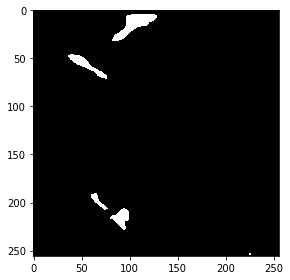

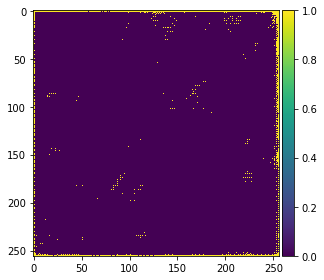

In [42]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(X_val)-1)
imshow(X_val[ix])
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [15]:
tn = 0.
fp = 0.
fn = 0.
tp = 0.
print(len(preds_test_t))
for ix in range(0, len(preds_test_t)):
    #print(ix)
    tn_, fp_, fn_, tp_ = confusion_matrix(Y_test[ix].astype(int).flatten(), preds_test_t[ix].astype(int).flatten(), labels=[0,1]).ravel()
    tn = tn + tn_
    fp = fp + fp_
    fn = fn + fn_
    tp = tp + tp_
#    print(tn, fp, fn, tp)

print(tn, fp, fn, tp)

3
120213.0 45200.0 21361.0 9834.0


In [18]:
tn = 0.
fp = 0.
fn = 0.
tp = 0.
print(len(preds_val_t))
for ix in range(0, len(preds_val_t)):
    #print(ix)
    tn_, fp_, fn_, tp_ = confusion_matrix(Y_val[ix].astype(int).flatten(), preds_val_t[ix].astype(int).flatten(), labels=[0,1]).ravel()
    tn = tn + tn_
    fp = fp + fp_
    fn = fn + fn_
    tp = tp + tp_
#    print(tn, fp, fn, tp)

print(tn, fp, fn, tp)

3
104437.0 44351.0 31436.0 16384.0


In [19]:
# # test images
# X_test = np.zeros((len(test_mask_pair), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_test = np.zeros((len(test_mask_pair), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

# sizes_test = []
# print('Resizing test images') 
# n = 0
# for key, value in tqdm(test_mask_pair.items()):   
#     img_path = value[0]
#     img = imread(img_path)[:,:,:IMG_CHANNELS]  
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_test[n] = img  #Fill empty X_train with values from img
#     mask_path = value[1]
#     mask = imread(mask_path)
#     mask = mask.reshape(256, 256, 1)
#     mask_bool = mask > 0          
#     Y_test[n] = mask_bool 
#     n += 1

# print('Done!')

NameError: name 'test_mask_pair' is not defined

In [ ]:
# Selecting test data samples
# Need to run once at the start
# print(img_mask_HCL_pair.keys)

# import shutil

# TEST_HCL_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_020/Test/img'
# TEST_HCL_MASK_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_020/Test/mask'

# TEST_HCR_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_021/Test/img'
# TEST_HCR_MASK_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_021/Test/mask'

# test_samples_HCL = random.choices(list(img_mask_HCL_pair.keys()), k=98)
# for sample in test_samples_HCL:
#     try:
#         img_path = img_mask_HCL_pair[sample][0]
#         img_test_path = os.path.join(TEST_HCL_PATH,img_path.split('/')[-1])
#         shutil.move(img_path, img_test_path)
#     #print(img_path)
#     #print(img_test_path)

#         mask_path = img_mask_HCL_pair[sample][1]
#         mask_test_path = os.path.join(TEST_HCL_MASK_PATH, mask_path.split('/')[-1])
#         shutil.move(mask_path, mask_test_path)
#     except:
#         print(sample)
#     #break;

# test_samples_HCR = random.choices(list(img_mask_HCR_pair.keys()), k=98)
# for sample in test_samples_HCR:
#     try:
#         img_path = img_mask_HCR_pair[sample][0]
#         img_test_path = os.path.join(TEST_HCR_PATH,img_path.split('/')[-1])
#         shutil.move(img_path, img_test_path)
    
#         mask_path = img_mask_HCR_pair[sample][1]
#         mask_test_path = os.path.join(TEST_HCR_MASK_PATH, mask_path.split('/')[-1])
#         shutil.move(mask_path, mask_test_path)    
#     except:
#         print(sample)